
# Float vertical position control, Ifremer prototype


---

## Equations of motion

For basics about float dynamics go [here](https://github.com/apatlpo/cognac/blob/master/instrum/float_dynamics_basics.ipynb)

We assume now that the float has the ability to control its volume between two bounds $V+v_{min}$ and $V+v_{max}$
with a precision $dv$.

---

## Control

We control the float vertical position with sliding modes, see [this notebook](https://github.com/apatlpo/cognac/blob/master/instrum/zcontrol_realistic.ipynb) for more details about control.


In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
from scipy.interpolate import interp1d
import time
from copy import deepcopy

from matplotlib import animation, rc
from IPython.display import HTML

from float_lib import *

WOA water profile at lon=-50, lat=40


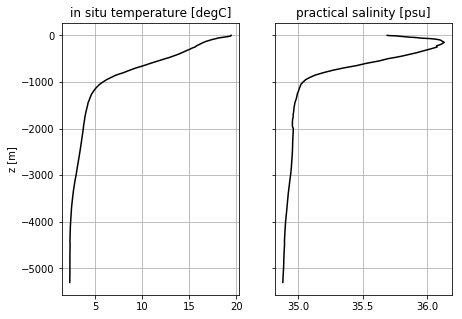

In [2]:
# select a water profile
w = waterp(lon=-50.,lat=40.)
print(w)
#w.show_on_map()

--- 
## Instantiate a stable float with varying volume

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-1000.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = autonomous_float(model='IFREMER')

# adjust mass to be at equilibrium at -1000m
iz = np.argmin(np.abs(z+1000))
f.adjust_m(p[iz],temp[iz],rho_w[iz])
# set vmax such that the float is neutral at the surface
iz = np.argmin(np.abs(z+0))
vmax = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz])
# set vmin such that the float is neutral at 1000m depth
iz = np.argmin(np.abs(z+1000))
vmin = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz])
# adjust vmax to be confortable at the surface - arbitrary !!!
vmax = vmax + (vmax-vmin)
#
#f.init_piston(vol_min=vmin,vol_max=vmax,vol=vmax)
f.init_piston(a=.01, lead=.003, d_max=.2)
# d_max is between .2-.4m or .2m-.5m depending on the jack choice
print(f)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

1696.0 g were added to the float in order to be at equilibrium at 1010 dbar 

Piston max volume set from max displacement
Float parameters: 
  L     = 0.80 m      - float length
  2a    = 0.12 m      - float diameter
  m     = 9.30 kg     - float radius
  V     = 9.05e+03 cm^3   - float volume
  gamma = 3.74e-06 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
Piston parameters and state: 
  2a    = 20.00 mm        - piston diameter
  phi   = 0.00 rad       - present angle of rotation
  d     = 0.00 mm        - present piston displacement
  vol   = 0.00 cm^3      - present volume addition
  lead  = 0.30 cm        - screw lead
  phi_max = 41887.90 deg     - maximum rotation
  phi_min = 0.00 deg     - minimum rotation
  d_max = 200.00 mm        - maximum piston displacement
  d_min = 0.00 mm        - minimum piston displacement
  vol_min = 0.00 cm^3    - min volume displaced
  vol_max = 62.83 cm^3   

In [4]:
# adjust piston to be at equilibrium 20m
iz = np.argmin(np.abs(z+250.))
vmax = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) ) # check

# compute float vertical displacement associated with 1mm piston displacement
f.piston.update_d(f.piston.d+.001)
f.piston_update_vol()
print('z equilibrium after 1 mm piston displacement = %.1fm' %(f.z4equilibrium(w) ) )

Piston reset : vol=1.3e+01 cm^3  
z equilibrium = -250.0m
z equilibrium after 1 mm piston displacement = -233.6m


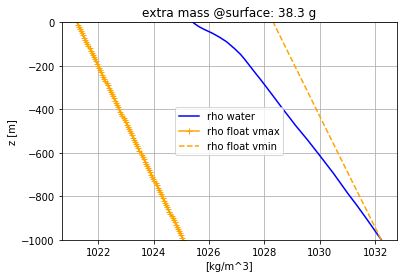

In [5]:
# show densities
plot_float_density(z, f, w)
#plot_float_volume(z, f, w)

---

## From the surface down to a target level

In [6]:
# we start by constructing a trajectory that can be followed by the float
z_target = descent(3600.*5, -250., f, w)

Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=4.0e-02 m^2/s, fmin/m= -9.3e-03 m^2/s, wmax= 18.0 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax 2.4e+02 cm/s, fmin/m= -5.6e+01 cm/s


In [7]:
# time step float with control
control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#
f.time_step(w, T=3600., dt_step=.1, dt_store=1., z=0., w=0., v=f.piston.vol_max,
             usepiston=True, z_target=z_target, ctrl=control)

 ctrl: tau = 10.0
 ctrl: dz_nochattering = 1.0
 ctrl: mode = sliding
 ctrl: Lv = 0.8
 ctrl: dt_ctrl = 0.1
 ctrl: d3y_ctrl = 0.04033975866644457
Start time stepping for 60 min ...
... time stepping done


Extrapolated energy conssumption: 9.1 Wh/day = 274.5 Wh/30day


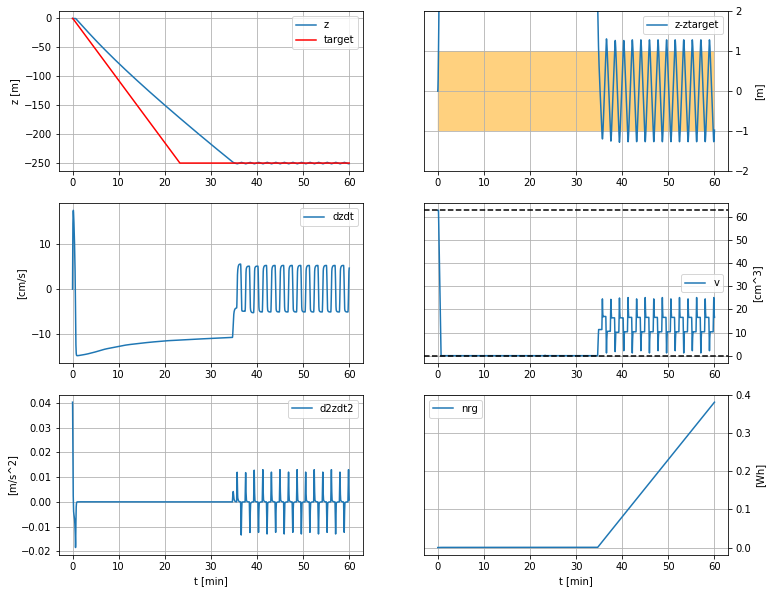

In [8]:
# plot log
plot_log(f, z_target=z_target)

---

## Oscillations around a fixed level

In [9]:
z_target = lambda t: -250+10.*np.sin(2.*np.pi/600.*t)

In [10]:
f.time_step(w, T=3600., dt_step=.1, dt_store=1., usepiston=True, z_target=z_target, ctrl=control)

 ctrl: tau = 10.0
 ctrl: dz_nochattering = 1.0
 ctrl: mode = sliding
 ctrl: Lv = 0.8
 ctrl: dt_ctrl = 0.1
 ctrl: d3y_ctrl = 0.04033975866644457
Start time stepping for 60 min ...
... time stepping done


Extrapolated energy conssumption: 16.7 Wh/day = 500.5 Wh/30day


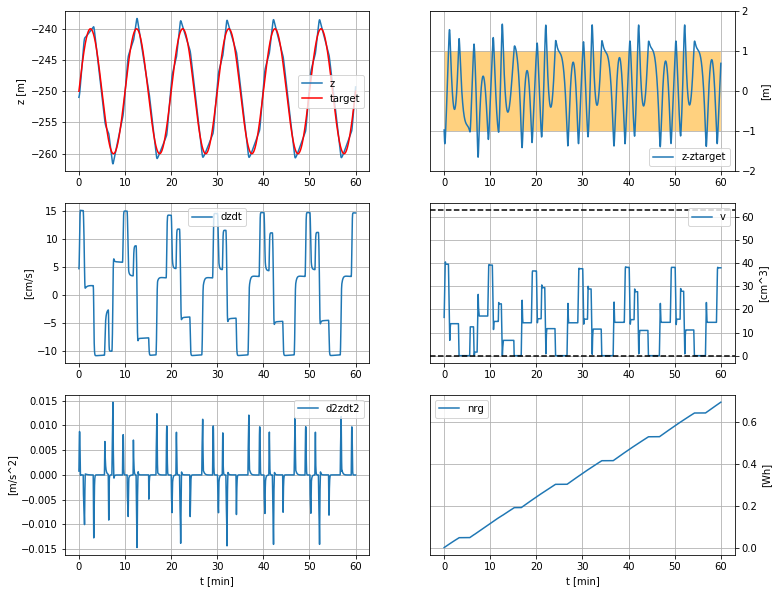

In [11]:
plot_log(f, z_target=z_target)

---

## Maintains depth level around moving isopycnals

In [13]:
eta = lambda t: 10.*np.sin(2.*np.pi/(60.*20.)*t)
z_target = lambda t: -250.+t*0.

In [14]:
f.time_step(w, T=3600., dt_step=.1, dt_store=1., usepiston=True, z_target=z_target, ctrl=control, eta=eta)

 ctrl: tau = 10.0
 ctrl: dz_nochattering = 1.0
 ctrl: mode = sliding
 ctrl: Lv = 0.8
 ctrl: dt_ctrl = 0.1
 ctrl: d3y_ctrl = 0.04033975866644457
Start time stepping for 60 min ...
... time stepping done


Extrapolated energy conssumption: 21.0 Wh/day = 630.8 Wh/30day


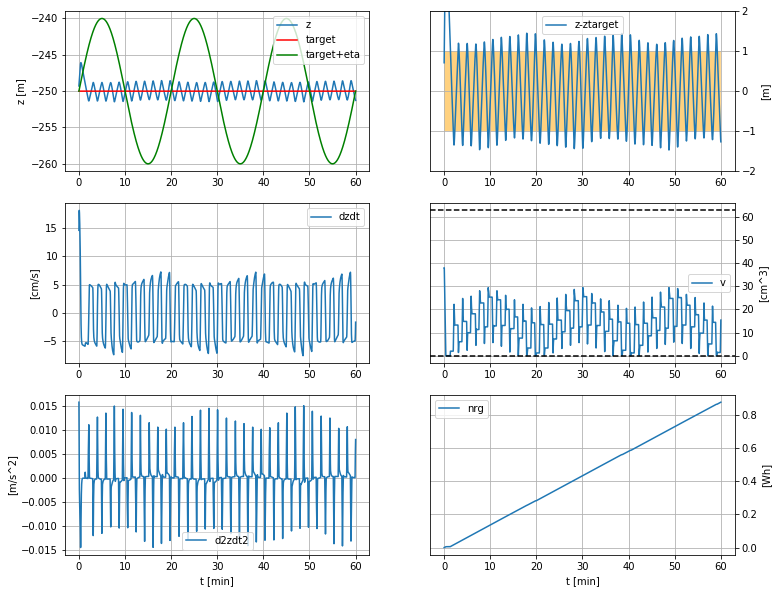

In [15]:
plot_log(f,z_target=z_target,eta=eta)

---

## Moving isopycnals without control

In [16]:
iz = np.argmin(np.abs(z+250.))
v = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz])
f.time_step(w, T=3600., dt_step=.1, dt_store=1., z=-250., w=0., v=v, usepiston=False, eta=eta)

Start time stepping for 60 min ...
... time stepping done


Extrapolated energy conssumption: 0.0 Wh/day = 0.0 Wh/30day


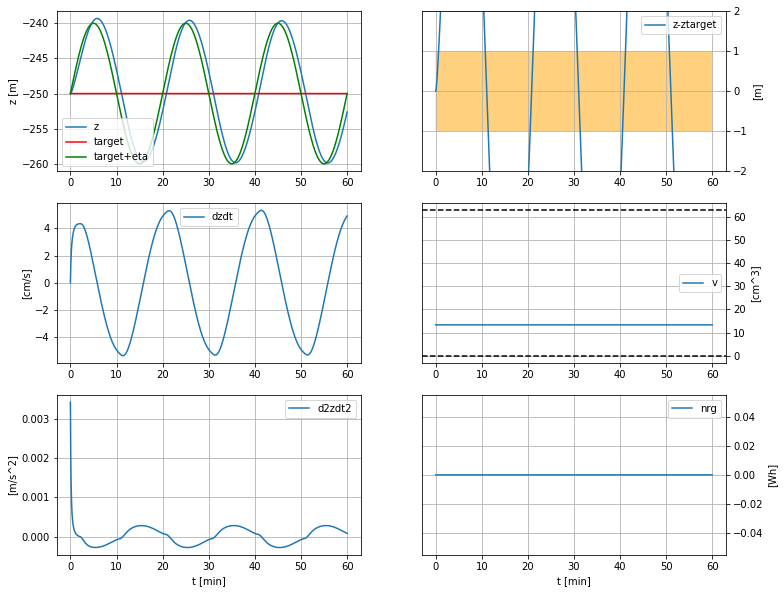

In [17]:
plot_log(f,z_target=z_target,eta=eta)